In [2]:
import pandas as pd
import skopt as sko
import numpy as np
import matplotlib.pyplot as plt

#Library to evaluate performance and optimize ML
#Parallelizing and memory evaluation obtained through this library.  
#https://joblib.readthedocs.io/en/stable/
from joblib import Memory, Parallel, delayed

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay as showMatrix
from sklearn.metrics import RocCurveDisplay

from collections import OrderedDict

#Utilizes Bayesian Search Optimizer from ScikitLearn Optimizer Library
#https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV
from skopt import BayesSearchCV

#Get rid of all the annoying BayesSearchCV warnings associated with the RandomForestClassifier
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')


In [3]:
#Very simplistic ML model for RandomForestClassifier running ML with 5 Fold Cross Validation
#Pull data
#Import data from white wines
whitewinedata = pd.read_csv("winequality-white.csv",sep=';')


#Determine which features are most correlated with predicted quality
display(whitewinedata.corr()['quality'].sort_values(ascending=False))

quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

In [4]:
#Pull out white wine labels
whitewinelabels = whitewinedata.pop('quality')

In [5]:
try: performance_scores = pd.read_excel('performance_scores.xlsx', index_col=None)
except: performance_scores = pd.DataFrame(columns=['Search_Type', 'Training_Accuracy', 'Test_Accuracy', 
                                          'Fit_Time', 'Best_Search_Accuracy_Score', 'Opt_Method', 'Best_Parameters'],index=None)


display(performance_scores)
#performance_scores.columns

,Search_Type,Training_Accuracy,Test_Accuracy,Fit_Time,Best_Search_Accuracy_Score,Opt_Method,Best_Parameters
0,BayesSearchCV,1.000000,0.652245,76.117536,0.674386,Full Train Set,"OrderedDict([('bootstrap', True), ('criterion'..."
1,BayesSearchCV,1.000000,0.684898,66.774137,0.660212,Full Train Set,"OrderedDict([('bootstrap', True), ('criterion'..."
2,RandomizedSearchCV,1.000000,0.663673,11.910216,0.664857,Full Train Set,"{'warm_start': False, 'n_jobs': -1, 'n_estimat..."
3,RandomizedSearchCV,1.000000,0.673469,7.671331,0.658314,Full Train Set,"{'warm_start': True, 'n_jobs': -1, 'n_estimato..."
4,GridSearchCV,1.000000,0.659592,27.170544,0.675481,Full_Train_Set,"{'bootstrap': True, 'criterion': 'gini', 'max_..."
5,GridSearchCV,1.000000,0.666122,26.610894,0.673301,Full_Train_Set,"{'bootstrap': True, 'criterion': 'entropy', 'm..."
6,GridSearchCV,1.000000,0.675102,28.026012,0.662666,Full_Train_Set,"{'bootstrap': True, 'criterion': 'entropy', 'm..."
7,BayesSearchCV,0.981481,0.611111,48.894397,0.565360,Meta 25%,"OrderedDict([('bootstrap', True), ('criterion'..."
8,BayesSearchCV,0.990196,0.581699,43.697065,0.598105,Meta 25%,"OrderedDict([('bootstrap', True), ('criterion'..."
9,BayesSearchCV,0.967320,0.588235,43.421470,0.588299,Meta 25%,"OrderedDict([('bootstrap', True), ('criterion'..."


In [6]:
#Split white datasets before anything to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(whitewinedata, whitewinelabels, random_state=24)

In [23]:
#get CV scores from dataset split into 5
rfc = RandomForestClassifier()

w_scores = cross_val_score(rfc, whitewinedata, whitewinelabels, cv=5)
print(scores)

r_scores = cross_val_score(rfc, red)
scores = pd.DataFrame(scores)
display(scores)

[0.51428571 0.48979592 0.56326531 0.50868233 0.53013279]


,0
0,0.514286
1,0.489796
2,0.563265
3,0.508682
4,0.530133


In [8]:
#run same with ShuffleSplit
n_samples = whitewinedata.shape[0]
cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
scores2 = cross_val_score(rfc, whitewinedata, whitewinelabels, cv=cv)

In [9]:
print(scores2)

[0.69897959 0.68163265 0.69591837 0.69152196 0.65372829]


In [10]:
#Define dict random forest hyperparameters from which to optimize/search
rfcparams = {
    'n_estimators': [10, 25, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 25],
    'bootstrap': [True, False],
    'warm_start': [True, False],
    'n_jobs': [-1]
}

In [11]:
#Define a list dataset features most important to model training


In [12]:
def report_perf(optimizer, tr_X, tr_y, te_X, te_y, title, subset):
    
    optimizer.fit(tr_X, tr_y)
    train_pred = optimizer.predict(tr_X)
    test_pred = optimizer.predict(te_X)
    train_acc = accuracy_score(train_pred, tr_y)
    test_acc = accuracy_score(test_pred, te_y)

    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    print(title, "best score:", optimizer.best_score_)
    print("best params: %s" % str(optimizer.best_params_))
    print("Best Estimator:", optimizer.best_estimator_)


    mean_fit_time = optimizer.cv_results_['mean_fit_time']
    mean_score_time = optimizer.cv_results_['mean_score_time']
    n_splits = optimizer.n_splits_ #Num splits of train data
    n_iter = pd.DataFrame(optimizer.cv_results_).shape[0] #Iterations per split
    time = np.mean(mean_fit_time+mean_score_time) * n_splits * n_iter
    
    print("Total Mean Time for ML (in seconds): ", np.mean(mean_fit_time+mean_score_time) * n_splits * n_iter)
    #print(test_pred)
    
    winematrix = confusion_matrix(te_y, test_pred)
    labels = np.unique(np.concatenate((te_y, test_pred),0))
    #hanldes situations in which we don't get a class 3 or 9 wine in predictors
    ix = y_test != 9
    
    if (type(optimizer.best_params_) == 'OrderedDict'):
        bestparams = optimizer.best_params_.items()
    else:
        bestparams = optimizer.best_params_
    
    performance_scores.loc[len(performance_scores)] = [title, train_acc, test_acc, time, 
                                                       optimizer.best_score_, subset,
                                                    str(bestparams)]

    disp = showMatrix(winematrix, display_labels=labels) 
    #roc = roc_auc_score(te_y[ix], optimizer.predict_proba(te_X[ix,:]), labels=labels, multi_class='ovo')
              
    disp.plot()
    plt.grid(False)
    plt.show()
    
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(optimizer, te_X, te_y, ax=ax, alpha=0.8)
    svc_disp.plot(ax=ax, alpha=0.8)
    
    return test_acc

Train Accuracy: 1.0
Test Accuracy: 0.6775510204081633
GridSearchCV best score: 0.66402750746075
best params: {'bootstrap': True, 'criterion': 'log_loss', 'max_depth': 25, 'n_estimators': 100, 'n_jobs': -1, 'warm_start': False}
Best Estimator: RandomForestClassifier(criterion='log_loss', max_depth=25, n_jobs=-1)
Total Mean Time for ML (in seconds):  33.11461615562439


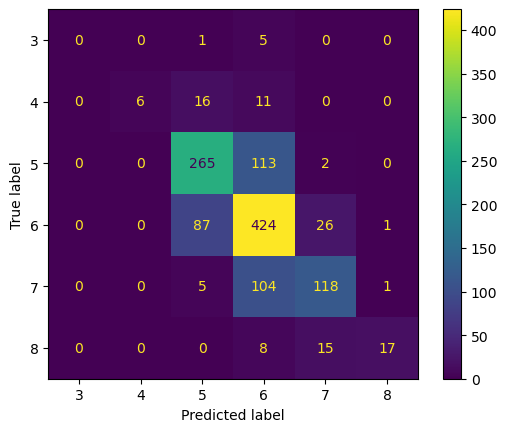

0.6775510204081633

In [13]:
#Perform a grid search on Hyperparameters for optimization
#Yes, I know... Ew.  
hp_searcher = GridSearchCV(rfc, param_grid=rfcparams, cv=cv)
report_perf(hp_searcher, X_train, y_train, X_test, y_test, "GridSearchCV", "Full_Train_Set")

Train Accuracy: 1.0
Test Accuracy: 0.686530612244898
BayesSearchCV best score: 0.6653880516784371
best params: OrderedDict([('bootstrap', True), ('criterion', 'log_loss'), ('max_depth', 25), ('n_estimators', 100), ('n_jobs', -1), ('warm_start', False)])
Best Estimator: RandomForestClassifier(criterion='log_loss', max_depth=25, n_jobs=-1)
Total Mean Time for ML (in seconds):  81.07771182060242


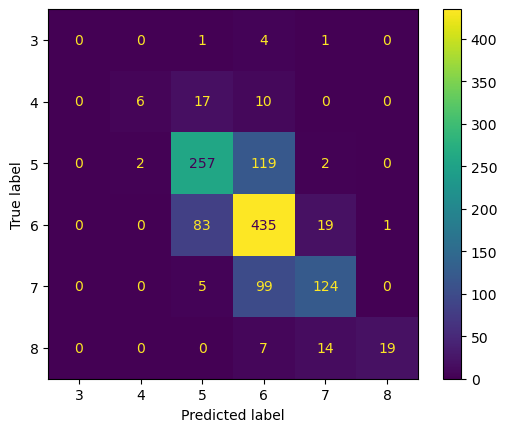

0.686530612244898

In [14]:
#Base Bayesian Search Optimizer from skopt:  
bayes_searcher = BayesSearchCV(estimator=rfc, search_spaces=rfcparams, n_jobs=-1, cv=cv)
report_perf(bayes_searcher, X_train, y_train, X_test, y_test, "BayesSearchCV", "Full Train Set")

Train Accuracy: 1.0
Test Accuracy: 0.6718367346938775
RandomizedSearchCV best score: 0.661851007432946
best params: {'warm_start': False, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
Best Estimator: RandomForestClassifier(criterion='entropy', n_jobs=-1)
Total Mean Time for ML (in seconds):  23.899622201919556


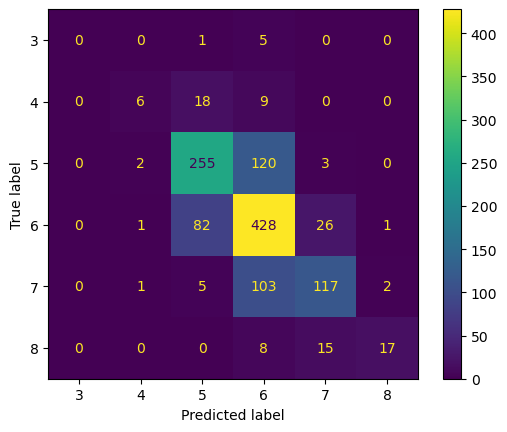

0.6718367346938775

In [15]:
#Try with dumb randomized searcher
rand_searcher = RandomizedSearchCV(estimator=rfc, param_distributions=rfcparams, n_jobs=-1, cv=cv)
report_perf(rand_searcher, X_train, y_train, X_test, y_test, "RandomizedSearchCV", "Full Train Set")

In [16]:
#Incorporate meta-learning on smaller subsets'
sample_wine = pd.read_csv("winequality-white.csv",sep=';').sample(frac=0.25)
sample_labels = sample_wine.pop('quality')

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(sample_wine, sample_labels, random_state=0)

/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Train Accuracy: 1.0
Test Accuracy: 0.5588235294117647
GridSearchCV best score: 0.5784271798526965
best params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100, 'n_jobs': -1, 'warm_start': True}
Best Estimator: RandomForestClassifier(bootstrap=False, criterion='entropy', n_jobs=-1,
                       warm_start=True)
Total Mean Time for ML (in seconds):  39.22216987609864


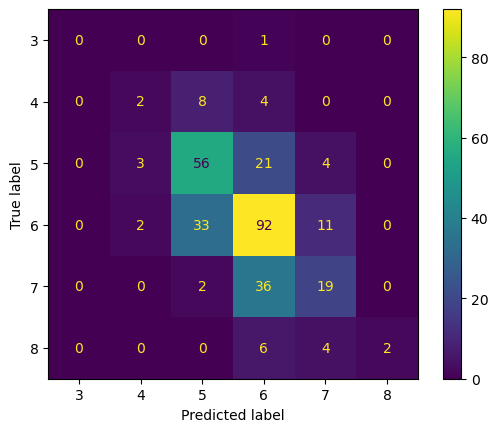

0.5588235294117647

In [17]:
#Note, this will fail because we don't have a sample with enough outliers to provide proper 
#predictions on outlying data so the classes don't match.
report_perf(hp_searcher, X_train_sample, y_train_sample, X_test_sample, y_test_sample, "GridSearchCV", "Meta 25%")

/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated

/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated

Train Accuracy: 0.9836601307189542
Test Accuracy: 0.5816993464052288
BayesSearchCV best score: 0.579543834640057
best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 10), ('n_estimators', 100), ('n_jobs', -1), ('warm_start', False)])
Best Estimator: RandomForestClassifier(criterion='entropy', max_depth=10, n_jobs=-1)
Total Mean Time for ML (in seconds):  49.935301780700684


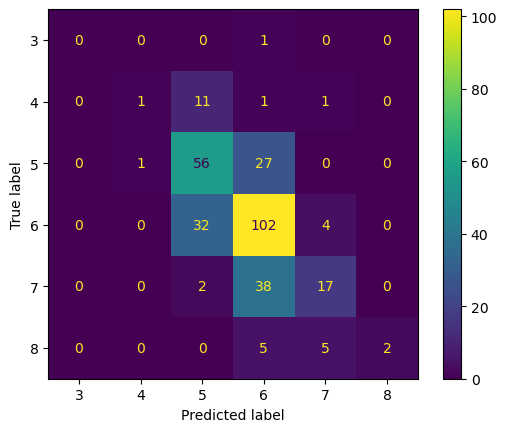

0.5816993464052288

In [18]:
#Note, this will fail because we don't have a sample with enough outliers to provide proper 
#predictions on outlying data so the classes don't match.
report_perf(bayes_searcher, X_train_sample, y_train_sample, X_test_sample, y_test_sample, "BayesSearchCV", "Meta 25%")

/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Train Accuracy: 1.0
Test Accuracy: 0.5947712418300654
RandomizedSearchCV best score: 0.5729864575908767
best params: {'warm_start': False, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 25, 'criterion': 'gini', 'bootstrap': True}
Best Estimator: RandomForestClassifier(max_depth=25, n_jobs=-1)
Total Mean Time for ML (in seconds):  4.656710624694824


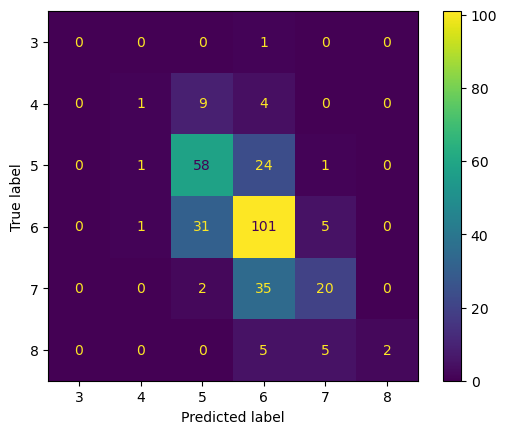

0.5947712418300654

In [19]:
#Note, this will fail because we don't have a sample with enough outliers to provide proper 
#predictions on outlying data so the classes don't match.
report_perf(rand_searcher, X_train_sample, y_train_sample, X_test_sample, y_test_sample, "RandomizedSearchCV", "Meta 25%")

In [20]:
display(performance_scores)

performance_scores.to_excel('performance_scores.xlsx', index=False)

,Search_Type,Training_Accuracy,Test_Accuracy,Fit_Time,Best_Search_Accuracy_Score,Opt_Method,Best_Parameters
0,BayesSearchCV,1.000000,0.652245,76.117536,0.674386,Full Train Set,"OrderedDict([('bootstrap', True), ('criterion'..."
1,BayesSearchCV,1.000000,0.684898,66.774137,0.660212,Full Train Set,"OrderedDict([('bootstrap', True), ('criterion'..."
2,RandomizedSearchCV,1.000000,0.663673,11.910216,0.664857,Full Train Set,"{'warm_start': False, 'n_jobs': -1, 'n_estimat..."
3,RandomizedSearchCV,1.000000,0.673469,7.671331,0.658314,Full Train Set,"{'warm_start': True, 'n_jobs': -1, 'n_estimato..."
4,GridSearchCV,1.000000,0.659592,27.170544,0.675481,Full_Train_Set,"{'bootstrap': True, 'criterion': 'gini', 'max_..."
5,GridSearchCV,1.000000,0.666122,26.610894,0.673301,Full_Train_Set,"{'bootstrap': True, 'criterion': 'entropy', 'm..."
6,GridSearchCV,1.000000,0.675102,28.026012,0.662666,Full_Train_Set,"{'bootstrap': True, 'criterion': 'entropy', 'm..."
7,BayesSearchCV,0.981481,0.611111,48.894397,0.565360,Meta 25%,"OrderedDict([('bootstrap', True), ('criterion'..."
8,BayesSearchCV,0.990196,0.581699,43.697065,0.598105,Meta 25%,"OrderedDict([('bootstrap', True), ('criterion'..."
9,BayesSearchCV,0.967320,0.588235,43.421470,0.588299,Meta 25%,"OrderedDict([('bootstrap', True), ('criterion'..."


In [21]:
average_scores = getaves()
display(average_scores)
plt.figure(figsize=(8,4))
ax = sb.barplot(x=average_scores['Model_Type'], y=average_scores['Test_Score'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

NameError: name 'getaves' is not defined